In [339]:
import pandas as pd
import json as js
import requests
from io import StringIO
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import numpy as np
import re

pd.set_option('display.float_format', '{:.0f}'.format) 

This section is what I tried in order to get the Billboard tables scraped. Because it's a complicated HTML structure (at least compared to Wikipedia) I had some trouble targeting it. I was getting errors until I spent an hour watching Beautifulsoup tutorials to try and target it, but decided it's worth it to explore other options first. If I end up needing this data I could give it another shot.

My (rough) idea now is to look at the number of times the top tours (maybe top five or so?) visited different cities and find which ones are the most visited. I think I would limit my analysis to cities in the US for the sake of brevity and also to ensure I have the right financial data. Something to consider would be the populations of the states as well, and how that could affect the number of times a city is visited. 

I'd also like to look into some kind of way to map the region of a city/venue. In my experience, artists will have two shows in California (North and South) and then a show in Chicago and Philidelphia and nothing in-between. Because of the population density, Chicago is like the bastion for concerts in the Midwest. It would be interesting to see region (and population) taken into account too to see how many are in each region.

In [340]:
url_wiki = 'https://www.billboard.com/2023-year-end-boxscore-charts/#pmc-protected-embed-2'

In [341]:
response1 = requests.get(url_wiki)
response1.status_code

200

In [342]:
soup = BeautifulSoup(response1.text, "html.parser")
the_table = soup.find('table',{'class':"medium datawrapper-OPu6B-sqmikr svelte-1smti70 striped compact resortable"})
print(the_table)

None


In [343]:
eras_tour = 'https://en.wikipedia.org/wiki/The_Eras_Tour#:~:text=Long%20Story%20Short%22-,Tour%20dates,-List%20of%202023'

In [344]:
response2 = requests.get(eras_tour)
response2.status_code

200

In [345]:
eras_tour_list = pd.read_html(StringIO(response2.text))
type(eras_tour_list)

list

I was a little surprised by how many things on Wikipedia pages are coded as tabled so it was mostly trial and error in terms of the index number to get the one I needed.

It was mentioned that the Wikipedia articles all cite data for their tables, but from my poking around it looks like they are once again citing Pollstar (paid) or an already put-together report, the same problems I've been running into. At least it's already concantenated for me though!

In [346]:
eras_2023 = eras_tour_list[5]
eras_2024 = eras_tour_list[6]

eras_2023.head()

,Date (2023),City,Country,Venue,Opening acts,Attendance,Revenue
0,March 17,Glendale,United States,State Farm Stadium,Paramore Gayle,—,—
1,March 18,Glendale,United States,State Farm Stadium,Paramore Gayle,—,—
2,March 24,Paradise[i],United States,Allegiant Stadium,Beabadoobee Gayle,—,—
3,March 25,Paradise[i],United States,Allegiant Stadium,Beabadoobee Gayle,—,—
4,March 31,Arlington,United States,AT&T Stadium,Muna Gayle,—,—


In [347]:
eras_2023['Date (2023)'] = eras_2023['Date (2023)'].astype(str) + ' 2023'
eras_2024['Date (2024)'] = eras_2024['Date (2024)'].astype(str) + ' 2024'

eras_2023.rename(columns={'Date (2023)': 'Date'}, inplace=True)
eras_2024.rename(columns={'Date (2024)': 'Date'}, inplace=True)

In [348]:
eras_tour_merged = pd.concat([eras_2023, eras_2024], axis = 0)
# eras_tour_merged.head()

Something I noticed with the Eras tour here as well is that very few dates are in the US (comparatively). Just skimming the Wikipedia article it looked a lot more global than it actually was, but nearly half of the dates were in the US. Glad I checked the numbers first before worrying about the results.

In [349]:
count_us_eras = (eras_tour_merged['Country'] == 'United States').sum()
print("Times in US:", count_us_eras)

count_global_eras = eras_tour_merged['Country'].ne('United States').sum()
print("Times Abroad:", count_global_eras)

Times in US: 62
Times Abroad: 88


In [350]:
ej = 'https://en.wikipedia.org/wiki/Farewell_Yellow_Brick_Road'

In [351]:
response3 = requests.get(ej)
response3.status_code

200

In [352]:
ej_list = pd.read_html(StringIO(response3.text))
type(ej_list)

list

In [353]:
ej_tours = ej_list[1]
ej_tours.head()

,Date,City,Country,Venue,Attendance,Revenue
,North America[32][33][34],North America[32][33][34],North America[32][33][34],North America[32][33][34],North America[32][33][34],North America[32][33][34]
0,8 September 2018,Allentown,United States,PPL Center,"8,983 / 8,983","$1,492,859"
1,11 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
2,12 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
3,15 September 2018,Buffalo,United States,KeyBank Center,"15,581 / 15,641","$2,033,001"
4,16 September 2018,University Park,United States,Bryce Jordan Center,"12,421 / 12,421","$1,662,468"


So I'd have to do some work to see if this table is busted (I don't think so, but the North America being included in the header is weirding me out. It's a subheader on the page, I just don't know if it would mess up any of the other data), but this seemed a lot more US-heavy looking at the page.

Something I'm concerned about is that this tour ended in the first half of 2023. Would I use the data from 2018-2022 if I was using financial data from 2023? Most of the 2023 dates are outside of the US, anyways. There's a chance I may not use financial data anyways and instead use regional and financial, but still something to think about.

In [354]:
count_us_ej = (ej_tours['Country'] == 'United States').sum()
print("Times in US:", count_us_ej)

count_global_ej = ej_tours['Country'].ne('United States').sum()
print("Times Abroad:", count_global_ej)

Times in US: North America[32][33][34]    163
dtype: int64
Times Abroad: North America[32][33][34]    176
dtype: int64


The Eras is #1 on the list of top-grossing tours and Elton John is #3. Since all of the other pages follow the same format I'll skip adding them for now, but as of writing I'm planning on doing the top 5 or maybe top 10 of these datasets.

In [355]:
df = pd.read_excel(r'C:\Users\gamec\Downloads\q3t3.xlsx')
# df.head()

Ughh, for readibility (I think) the excel sheet has blank cells on either side of the numbers. Unsure how to remove that logically but I'm sure there's an easy way.

So, now the idea is to get all of the dataframes in, add the artists/tour to each one, concantenate them into one big dataset(?), remove all the tour stops that aren't from the United States, group them by city, manually add the states for each city (scripted since there are duplicates), and then begin running some data from there. The verdict is out on whether I want to add the region too. We'll see :)

Maybe worth noting I haven't paid more than $20 for a concert ticket in 10 years. This is a foreign world to me lol

# ANALYSIS PLAN

First, I removed the opening acts from the eras tour chart since we won't need that information and I needed the number of columns to match the rest of the datasets. If you look back, I changed the code for the merged eras tour to not have the years in separate columns by appending the year to each cell and then renaming the column before merging into the merged table. The dates are in different format (Elton John is British), but as of now I'm not planning on using dates so I'm choosing not to worry.

In [356]:
eras_tour_merged.drop(['Opening acts'], axis=1, inplace=True)
eras_tour_merged.head()

,Date,City,Country,Venue,Attendance,Revenue
0,March 17 2023,Glendale,United States,State Farm Stadium,—,—
1,March 18 2023,Glendale,United States,State Farm Stadium,—,—
2,March 24 2023,Paradise[i],United States,Allegiant Stadium,—,—
3,March 25 2023,Paradise[i],United States,Allegiant Stadium,—,—
4,March 31 2023,Arlington,United States,AT&T Stadium,—,—


I tried a couple different scripts to do this but I kept removing the date and keeping the North America part, so I just did it manually

In [357]:
ej_tours.columns = ['Date', 'City', 'Country', 'Venue', 'Attendance', 'Revenue']
ej_tours.head()

,Date,City,Country,Venue,Attendance,Revenue
0,8 September 2018,Allentown,United States,PPL Center,"8,983 / 8,983","$1,492,859"
1,11 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
2,12 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
3,15 September 2018,Buffalo,United States,KeyBank Center,"15,581 / 15,641","$2,033,001"
4,16 September 2018,University Park,United States,Bryce Jordan Center,"12,421 / 12,421","$1,662,468"


Adding the artist so I can reference it later if needed

In [358]:
eras_tour_merged['Artist'] = "Taylor Swift"
ej_tours['Artist'] = "Elton John"

(Finally) merging the tables. 'inner' didn't work as a keyword so I used outer, as 'inner' was returning a blank table but I still need columns from both tables (please tell me if this is messing something up haha)

In [359]:
tours_merged = pd.merge(eras_tour_merged, ej_tours, how = 'outer')
tours_merged.head()

,Date,City,Country,Venue,Attendance,Revenue,Artist
0,1 April 2022[s],Indianapolis,United States,Gainbridge Fieldhouse,"14,789 / 14,789","$2,312,462",Elton John
1,1 December 2018,Atlanta,United States,State Farm Arena,"24,920 / 24,920","$3,310,272",Elton John
2,1 December 2019,Perth,Australia,Perth Oval,"44,079 / 45,415","$5,965,750",Elton John
3,1 February 2019,Inglewood,United States,The Forum,"29,408 / 29,408","$3,973,836",Elton John
4,1 February 2020[j],Coldstream,Australia,Rochford Winery Yarra Valley,"24,440 / 24,440","$2,699,520",Elton John


I only wanted to look at locations in the United States, and planned on using the .value_counts() function. I couldn't find a way to use that function with a conditional, so I just removed all the values that aren't from the US.

In [360]:
tours_merged = tours_merged[tours_merged['Country'] == 'United States']

Here is where I took the count of the # of times each venue appeared, and then converted that into a dataframe to be mapped. I know the proper way to do this and get rid of international venues would be through masking, but I was having trouble getting the mask to work in tandem with the bar plot, so this is temporary.

In the final, I will have assigned states to each city, and will likely be going by state. I don't think it will be necessary to not graph states that were only visited once, but due to the sheer # of titles at the bottom, this time I'm only including cities that have been visited more than three times.

I am not currently sure if I am going to continue with the venue name or the city name. I am not sure how I could append the city name to this dataframe in order to keep both. I plan on using some kind of script, so I could just append it like I added '2023' to the end of the cells for the Eras tour dates.

In [361]:
venue_counts = tours_merged['Venue'].value_counts()
venue_counts_df = venue_counts.reset_index()

venue_counts_df = venue_counts_df[venue_counts_df['count'] > 3]
# venue_counts_df

In [362]:
venue_counts_df.columns

Index(['Venue', 'count'], dtype='object')

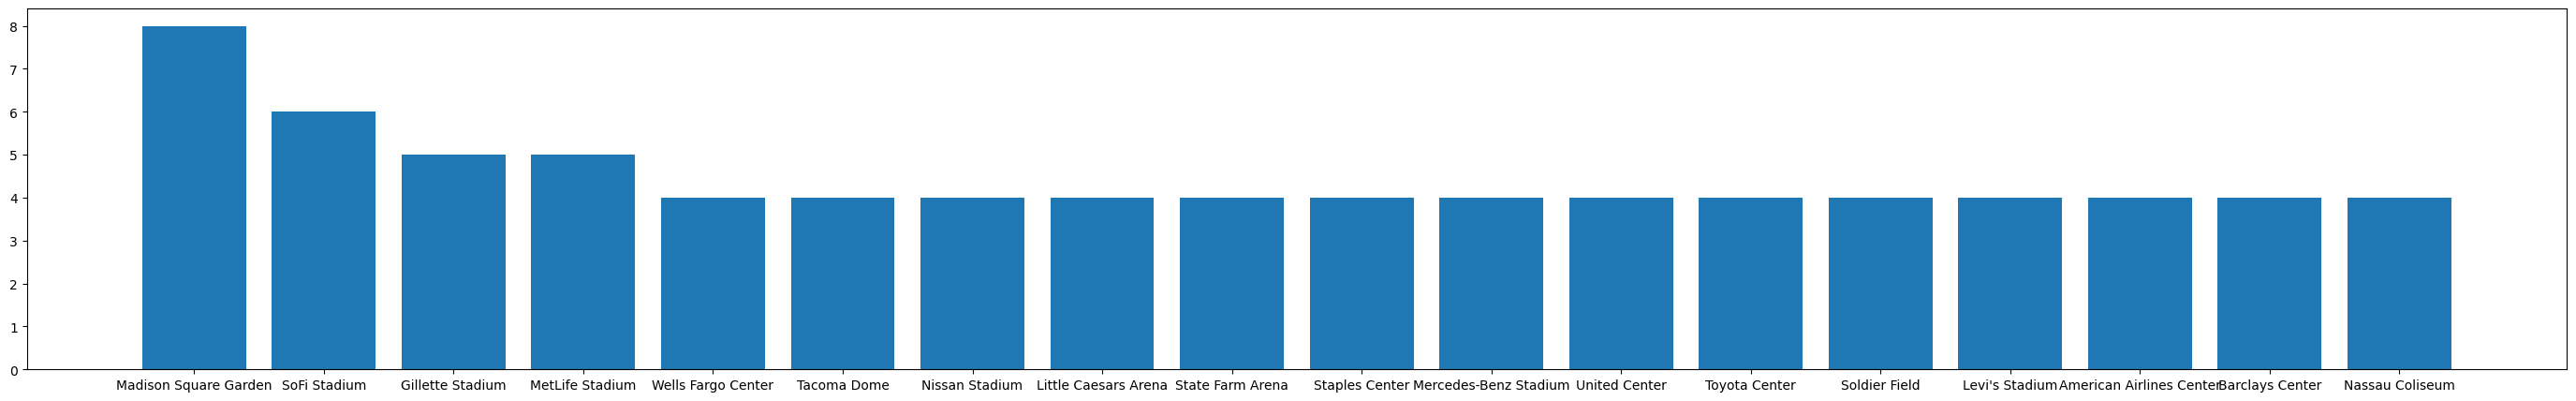

In [363]:
fig1, ax1 = plt.subplots(figsize = (35,5))
ax1.bar(venue_counts_df['Venue'], venue_counts_df['count'])

plt.show()

I think continuing my analysis I will look at the population of each city as well as the arts spending. Of the top five, I was not shocked to see MSG, SoFi, and MetLife (NYC (and New Jersey) and LA) but I was a little shocked to see Gillette stadium - if I was planning a major stadium tour, I would just assume NYC is close enough for people in Boston to take a bus.

Once again, for my final project I plan on adding states to each stadium. I will work on that, I just didn't have time for this checkpoint since I have to travel home for Thanksgiving. It would be really cool if I had time to implement a kind of heat map of the cities in my final project, to see where even within the states they are, but the current vision is a chart that graphs the income of a state alongside the # of times a state has been visited.

# DATA ANALYSIS

Here I am adding the final three tours, to bring it up to five. It could certainly benefit by adding more, but that's past the scope of this project.

In [364]:
c_tour = 'https://en.wikipedia.org/wiki/Music_of_the_Spheres_World_Tour'

In [365]:
response4 = requests.get(c_tour)
response4.status_code

200

In [366]:
coldplay = pd.read_html(StringIO(response4.text))
type(coldplay)

list

In [367]:
coldplay_tour_22 = coldplay[2]
coldplay_tour_23 = coldplay[3]
coldplay_tour_24 = coldplay[4]
coldplay_tour_25 = coldplay[5]

In [368]:
coldplay_tour_22['Date (2022)'] = coldplay_tour_22['Date (2022)'].astype(str) + ' 2022'
coldplay_tour_22.rename(columns={'Date (2022)': 'Date'}, inplace=True)

coldplay_tour_23['Date (2023)'] = coldplay_tour_23['Date (2023)'].astype(str) + ' 2023'
coldplay_tour_23.rename(columns={'Date (2023)': 'Date'}, inplace=True)

coldplay_tour_24['Date (2024)'] = coldplay_tour_24['Date (2024)'].astype(str) + ' 2024'
coldplay_tour_24.rename(columns={'Date (2024)': 'Date'}, inplace=True)

coldplay_tour_25['Date (2025)'] = coldplay_tour_25['Date (2025)'].astype(str) + ' 2025'
coldplay_tour_25.rename(columns={'Date (2025)': 'Date'}, inplace=True)

In [369]:
coldplay_merged = pd.concat([coldplay_tour_22, coldplay_tour_23, coldplay_tour_24, coldplay_tour_25], axis = 0)

coldplay_merged.drop(['Opening acts'], axis=1, inplace=True)
coldplay_merged['Artist'] = "Coldplay"

coldplay_merged.head()

,Date,City,Country,Venue,Attendance,Revenue,Artist
0,18 March 2022,San José,Costa Rica,Estadio Nacional de Costa Rica,"86,199 / 86,199","$5,687,127",Coldplay
1,19 March 2022,San José,Costa Rica,Estadio Nacional de Costa Rica,"86,199 / 86,199","$5,687,127",Coldplay
2,22 March 2022,Santo Domingo,Dominican Republic,Estadio Olímpico Félix Sánchez,"30,524 / 30,524","$2,571,873",Coldplay
3,25 March 2022,Guadalupe[i],Mexico,Estadio BBVA,"112,262 / 112,262","$8,996,432",Coldplay
4,26 March 2022,Guadalupe[i],Mexico,Estadio BBVA,"112,262 / 112,262","$8,996,432",Coldplay


In [370]:
es_tour = 'https://en.wikipedia.org/wiki/%C3%B7_Tour'

In [371]:
response5 = requests.get(es_tour)
response5.status_code

200

In [372]:
sheeran = pd.read_html(StringIO(response5.text))

In [373]:
divide_tour_1 = sheeran[1]
divide_tour_2 = sheeran[2]

# divide_tour_1.head()

In [374]:
divide_tour_2.columns = ['Date', 'City', 'Country', 'Venue', 'Opening acts', 'Attendance', 'Revenue']

divide_tour_1['Dates (2017)'] = divide_tour_1['Dates (2017)'].astype(str) + ' 2017'
divide_tour_1.rename(columns={'Dates (2017)': 'Date'}, inplace=True)

divide_tour_2['Date'] = divide_tour_2['Date'].astype(str) + ' 2018'

# divide_tour_1.head()

In [375]:
divide_merged = pd.concat([divide_tour_1, divide_tour_2], axis = 0)

divide_merged.drop(['Opening acts'], axis=1, inplace=True)
divide_merged.drop(['Opening act(s)'], axis=1, inplace=True)
divide_merged['Artist'] = "Ed Sheeran"

divide_merged.head()

,Date,City,Country,Venue,Attendance,Revenue,Artist
0,16 March 2017,Turin,Italy,Pala Alpitour,"23,256 / 23,256","$1,219,480",Ed Sheeran
1,17 March 2017,Turin,Italy,Pala Alpitour,"23,256 / 23,256","$1,219,480",Ed Sheeran
2,19 March 2017,Zürich,Switzerland,Hallenstadion,"14,444 / 14,444","$1,148,585",Ed Sheeran
3,20 March 2017,Munich,Germany,Olympiahalle,"12,076 / 12,108","$919,768",Ed Sheeran
4,22 March 2017,Mannheim,Germany,SAP Arena,"10,843 / 10,848","$740,662",Ed Sheeran


In [376]:
u2 = 'https://en.wikipedia.org/wiki/U2_360%C2%B0_Tour'

In [377]:
response6 = requests.get(u2)
response6.status_code

200

In [378]:
u2_tour = pd.read_html(StringIO(response6.text))

In [379]:
u2_tour_df = u2_tour[1]
u2_tour_df.head()

,Date,City,Country,Venue,Opening act,Attendance,Revenue
,Leg 1 — Europe[121][122],Leg 1 — Europe[121][122],Leg 1 — Europe[121][122],Leg 1 — Europe[121][122],Leg 1 — Europe[121][122],Leg 1 — Europe[121][122],Leg 1 — Europe[121][122]
0,30 June 2009,Barcelona,Spain,Camp Nou,Snow Patrol,"182,055 / 182,055","$19,825,497"
1,2 July 2009,Barcelona,Spain,Camp Nou,Snow Patrol,"182,055 / 182,055","$19,825,497"
2,7 July 2009,Milan,Italy,San Siro,Snow Patrol,"153,806 / 153,806","$15,168,799"
3,8 July 2009,Milan,Italy,San Siro,Snow Patrol,"153,806 / 153,806","$15,168,799"
4,11 July 2009,Saint-Denis,France,Stade de France,Kaiser Chiefs,"186,544 / 186,544","$20,902,760"


In [380]:
u2_tour_df.columns = ['Date', 'City', 'Country', 'Venue', 'Opening acts', 'Attendance', 'Revenue']

u2_tour_df.drop(['Opening acts'], axis=1, inplace=True)
u2_tour_df['Artist'] = "U2"

Love On Tour is actually the sixth tour added. The Eras Tour does not have data for the attendance or revenue broken down by show, so I felt a lot of data would be missing. Initially I planned on getting rid of the Eras Tour, but could use it's data for the states.

In [381]:
hs = 'https://en.wikipedia.org/wiki/Love_On_Tour'

In [382]:
response7 = requests.get(hs)
response7.status_code

200

In [383]:
hs_tour = pd.read_html(StringIO(response7.text))

In [384]:
hs_tour_21 = hs_tour[2]
hs_tour_22 = hs_tour[3]
hs_tour_23 = hs_tour[4]

In [385]:
hs_tour_21['Date (2021)'] = hs_tour_21['Date (2021)'].astype(str) + ' 2021'
hs_tour_21.rename(columns={'Date (2021)': 'Date'}, inplace=True)

hs_tour_22['Date (2022)'] = hs_tour_22['Date (2022)'].astype(str) + ' 2022'
hs_tour_22.rename(columns={'Date (2022)': 'Date'}, inplace=True)

hs_tour_23['Date (2023)'] = hs_tour_23['Date (2023)'].astype(str) + ' 2023'
hs_tour_23.rename(columns={'Date (2023)': 'Date'}, inplace=True)

In [386]:
hs_merged = pd.concat([hs_tour_21, hs_tour_22, hs_tour_23], axis = 0)

hs_merged.drop(['Opening acts'], axis=1, inplace=True)
hs_merged['Artist'] = "Harry Styles"

Really funky way of finally merging all of the dataframes together

In [387]:
tours_merged_df = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(hs_merged, ej_tours, how = 'outer'), divide_merged, how='outer'), coldplay_merged, how = 'outer'), u2_tour_df, how = 'outer'), eras_tour_merged, how = 'outer')
tours_merged_df.head()

,Date,City,Country,Venue,Attendance,Revenue,Artist
0,1 April 2017,Herning,Denmark,Jyske Bank Boxen,"14,996 / 14,996","$1,268,365",Ed Sheeran
1,1 April 2018,Dunedin,New Zealand,Forsyth Barr Stadium,"105,014 / 105,014","$8,475,218",Ed Sheeran
2,1 April 2022[s],Indianapolis,United States,Gainbridge Fieldhouse,"14,789 / 14,789","$2,312,462",Elton John
3,1 August 2009,Gothenburg,Sweden,Ullevi,"119,297 / 119,297","$11,047,995",U2
4,1 August 2017,Sacramento,United States,Golden 1 Center,"13,424 / 13,424","$1,220,937",Ed Sheeran


Getting rid of all dates that aren't in the US

In [388]:
tours_merged_df = tours_merged_df[tours_merged_df['Country'] == 'United States']

Some of the cities had citations like [i] so they weren't registering as being the same, so got rid of all of those

In [389]:
tours_merged_df['City'] = tours_merged_df['City'].str.replace(r'\[.*?\]', '', regex=True)

Again, getting rid of all the extra characters and then converting it to numeric. I might have been able to keep the '$' but I wasn't sure so I just cut it.

In [390]:
tours_merged_df['Revenue'] = tours_merged_df['Revenue'].str.replace('$', '')
tours_merged_df['Revenue'] = tours_merged_df['Revenue'].str.replace(',', '')
tours_merged_df['Revenue'] = tours_merged_df['Revenue'].str.replace('—', '')
tours_merged_df['Revenue'] = tours_merged_df['Revenue'].str.replace(r'\[.*?\]', '', regex=True)

In [391]:
tours_merged_df['Revenue'] = pd.to_numeric(tours_merged_df['Revenue'])

Here is where I messed with the idea of separating attendance and capacity. I don't think I see a need since a large large majority would be sold out.

In [392]:
'''tours_merged_df[['Attendees', 'Capacity']] = tours_merged_df['Attendance'].str.split(' / ', expand = True)
tours_merged_df.head()'''

"tours_merged_df[['Attendees', 'Capacity']] = tours_merged_df['Attendance'].str.split(' / ', expand = True)\ntours_merged_df.head()"

Same as the revenue, making it numerical

In [393]:
tours_merged_df['Attendance'] = tours_merged_df['Attendance'].str.split(' ').str[0]
tours_merged_df['Attendance'] = tours_merged_df['Attendance'].str.replace(',', '')
tours_merged_df['Attendance'] = tours_merged_df['Attendance'].str.replace('—', '')
tours_merged_df['Attendance'] = tours_merged_df['Attendance'].str.replace(r'\[.*?\]', '', regex=True)

In [394]:
tours_merged_df['Attendance'] = pd.to_numeric(tours_merged_df['Attendance'])

Getting all of the unique cities so I can manually build a city dictionary

In [454]:
unique_values = tours_merged_df['City'].unique()
unique_values = unique_values.tolist()

unique_values.sort()

# print(unique_values)

Here is where I got worried that there might be venues in Portland, Oregon as well as Portland, Maine, but I guess the city in Maine is not as big as I thought. Most of the cities I knew only had one (i.e. Hollywood) and I knew the state immediately, but for the handful I wasn't sure about I would plug the city in here and then Google the venue to confirm the state.

In [396]:
tours_merged_df.loc[tours_merged_df['City'] == 'Portland']

,Date,City,Country,Venue,Attendance,Revenue,Artist
114,12 January 2019,Portland,United States,Moda Center,14584,1843608,Elton John
797,30 July 2017,Portland,United States,Moda Center,13420,1074959,Ed Sheeran
993,8 November 2021,Portland,United States,Moda Center,17890,2125697,Harry Styles


Defining the function for assigning each city a state.

In [397]:
def set_value(row_number, assigned_value):
    return assigned_value[row_number]

In [398]:
states_dictionary = pd.read_csv(r"C:\Users\gamec\Desktop\School\Data in Emat\states-dictionary.txt")

PLEASE forgive me for this awful dictionary - I know. I loaded it in as a text file but I keep getting an error code that I can't deal with right now, by the time you see it I will have discussed it with you and fixed the problem for the final.

In [399]:
cities_dictionary = {'Albany' : 'New York',
'Allentown' : 'Pennsylvania',
'Anaheim' : 'California',
'Arlington' : 'Texas',
'Atlanta' : 'Georgia',
'Austin' : 'Texas',                     
'Baltimore' : 'Maryland',
'Birmingham' : 'Alabama',
'Boise' : 'Idaho',
'Boston' : 'Massachusetts',
'Brooklyn' : 'New York',
'Buffalo' : 'New York',
'Charleston' : 'North Carolina',
'Charlotte' : 'North Carolina',
'Charlottesville': 'Virginia',
'Chicago' : 'Illinois',
'Cincinnati' : 'Ohio',
'Cleveland' : 'Ohio',
'Columbia' : 'South Carolina',
'Columbus': 'Ohio',
'Dallas' : 'Texas',
'Denver' : 'Colorado',
'Des Moines' : 'Iowa',
'Detroit' : 'Michigan',
'Duluth' : 'Georgia',
'East Lansing' : 'Michigan',
'East Rutherford' : 'New Jersey',
'Elmont' : 'New York',                     
'El Paso' : 'Texas',
'Fargo' : 'North Dakota',
'Foxborough' : 'Massachussets',
'Fresno' : 'California',
'Glendale' : 'California',
'Grand Rapids' : 'Michigan',
'Greensboro' : 'North Carolina',
'Hartford' : 'Connecticut',
'Hershey' : 'Pennsylvania',
'Hollywood' : 'California',
'Houston' : 'Texas',
'Indianapolis' : 'Indiana',
'Inglewood' : 'California',
'Jacksonville' : 'Florida',
'Kansas City' : 'Missouri',
'Knoxville' : 'Tennessee',
'Landover' : 'Maryland',
'Las Vegas' : 'Nevada',
'Lexington' : 'Kentucky',
'Lincoln' : 'Nebraska',
'Los Angeles' : 'California',
'Louisville' : 'Kentucky',
'Madison' : 'Wisconsin',
'Memphis' : 'Tennessee',
'Miami' : 'Florida',
'Miami Gardens' : 'Florida',
'Milwaukee' : 'Wisconsin',
'Minneapolis' : 'Minnesota',
'Nashville' : 'Tennessee',
'New Orleans' : 'Louisiana',
'New York City' : 'New York',
'Newark' : 'New Jersey',
'Norman' : 'Oklahoma',
'North Charleston' : 'South Carolina',
'North Little Rock' : 'Arkansas',
'Oakland' : 'California',
'Oklahoma City' : 'Oklahoma',
'Omaha' : 'Nebraska',
'Orlando' : 'Florida',
'Paradise' : 'Nevada',
'Pasadena' : 'California',
'Philadelphia' : 'Pennsylvania',
'Phoenix' : 'Arizona',
'Pittsburgh' : 'Pennsylvania',
'Portland' : 'Oregon',
'Raleigh' : 'North Carolina',
'Rosemont' : 'Illinois',
'Sacramento' : 'California',
'Saint Paul' : 'Minnesota',
'Salt Lake City' : 'Utah',
'San Antonio' : 'Texas',
'San Diego' : 'California',
'San Francisco' : 'California',
'San Jose' : 'California',
'Santa Clara' : 'California',
'Seattle' : 'Washington',
'St. Louis' : 'Missouri',
'Stanford' : 'California',
'Sunrise' : 'Florida',
'Syracuse' : 'New York',
'Tacoma' : 'Washington',
'Tampa' : 'Florida',
'Thousand Palms' : 'California',                     
'Tulsa' : 'Oklahoma',
'Uncasville': 'Connecticut',
'Uniondale' : 'New York',
'University Park' : 'Pennsylvania',
'Washington, D.C.' : 'Washington, D.C.',
'Whitney' : 'Nevada'}

Applying the dictionary. Building the dictionary honestly only took about 10 minutes of active work since I knew most of the information off-hand. Maybe a more sophisticated data scientist with a larger set (top 100 tours or something) would be able to compare a table of all music venues that contains states or something and automatically assign it. I don't know. Oh well.

In [400]:
tours_merged_df['State'] = tours_merged_df['City'].apply(set_value, args=(cities_dictionary, ))

Here is where I start to get into the actual graphing portion.

Creating a dataframe that counts the instances of each state appearing in the dataframe and includes the name of the state with how many times it was visited by artists.

In [401]:
state_count_df = tours_merged_df['State'].value_counts().rename_axis('State').reset_index(name='Count')
# state_count_df

Because the dataset is so huge, I couldn't get a histogram to work with all of them. So I split it into two. Probably won't be a histogram in the future but I'm not sure what else to do in order to keep the states neatly labeled. Would the states with lower numbers even be relevant?

In [402]:
less_than_ten = state_count_df[state_count_df['Count'] < 10]
more_than_ten = state_count_df[state_count_df['Count'] > 10]

As I assumed, California had the most visits to the state. Unsurprising. Hypothesis would be that's because it has so many cities.

Text(0.5, 0.98, 'Times each state was visited')

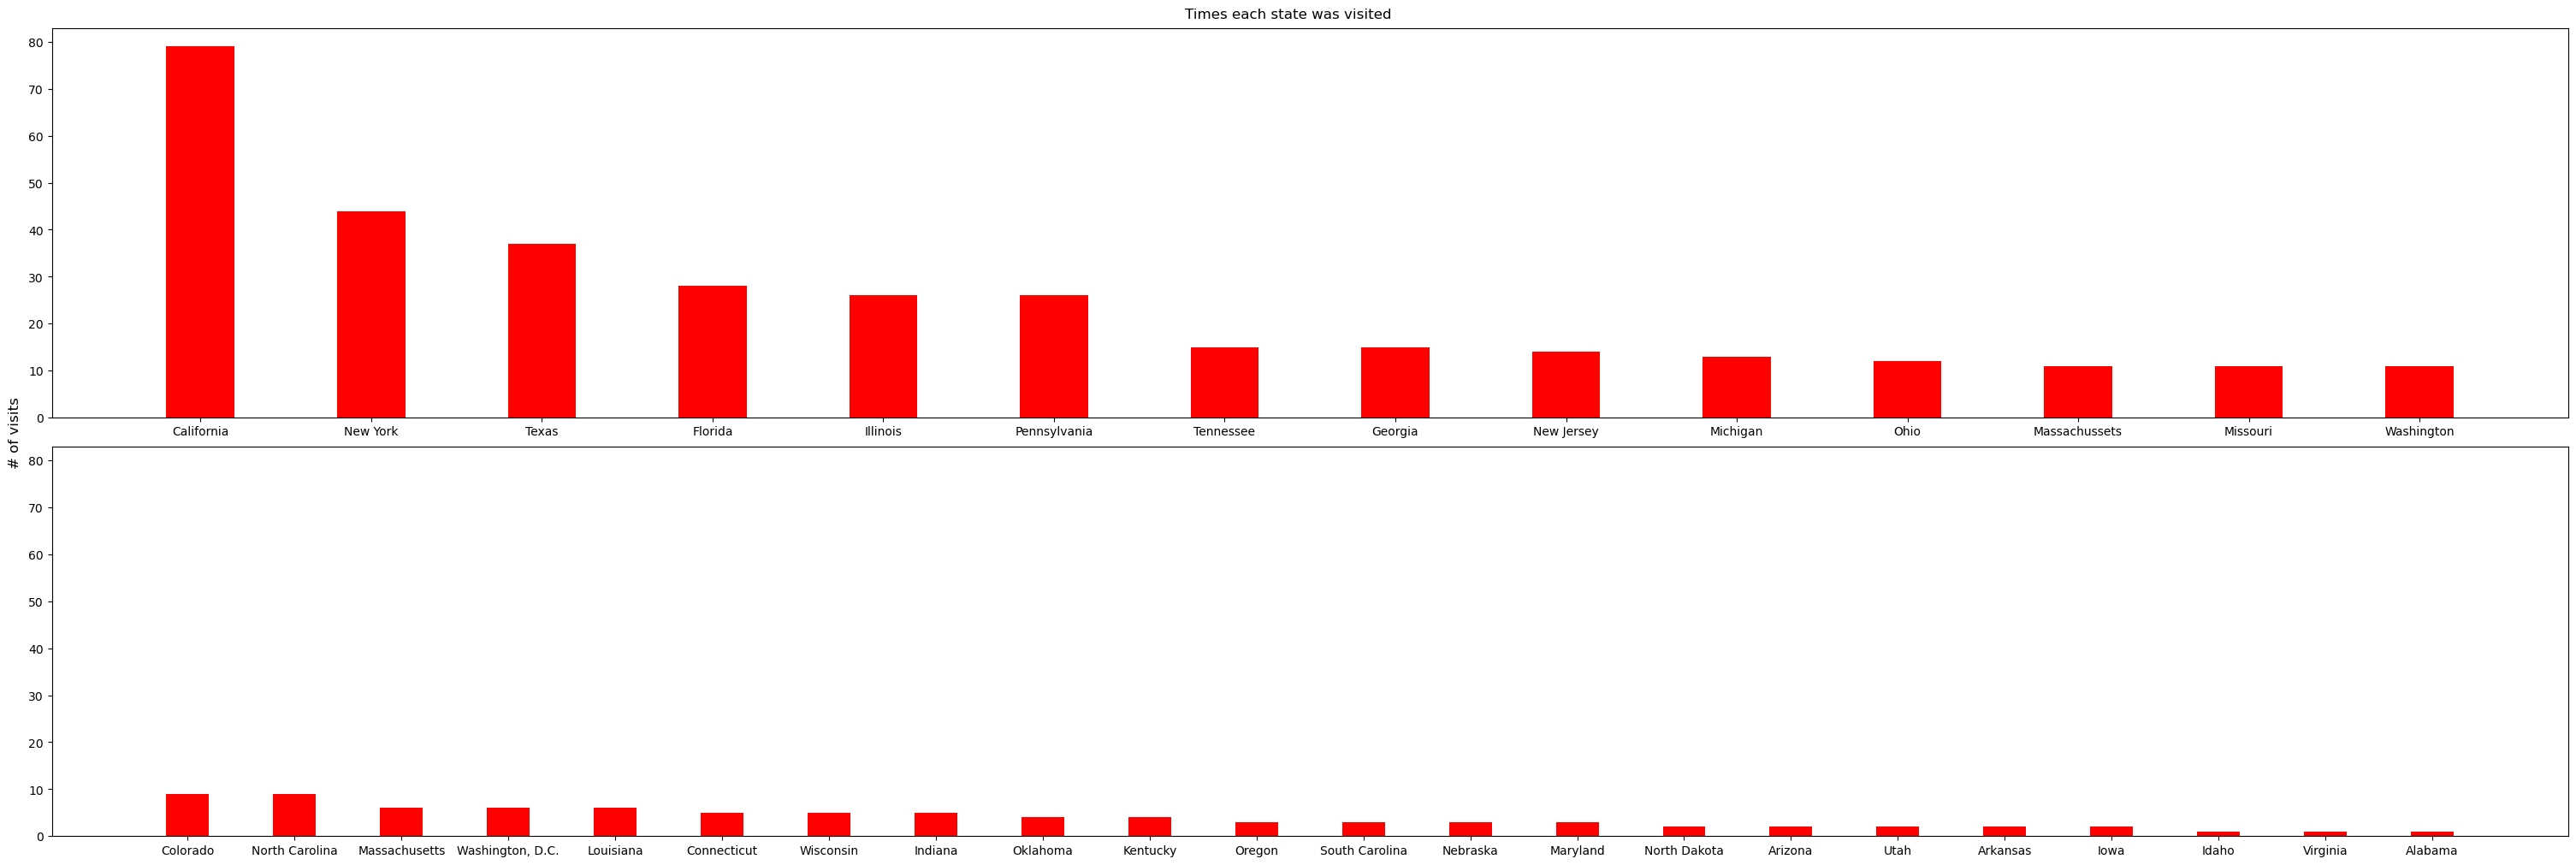

In [453]:
fig1, ax1 = plt.subplots(2,1, figsize = (30,10), sharey = True, layout='constrained')
ax1[0].bar(more_than_ten['State'], more_than_ten['Count'], color ='red', width = 0.4)

ax1[1].bar(less_than_ten['State'], less_than_ten['Count'], color ='red', width = 0.4)
fig1.supylabel('# of visits')
fig1.suptitle('Times each state was visited')

Rather than just creating a list of unique cities, this creates a dataframe that includes the state as well.

In [404]:
unique_cities = pd.DataFrame.from_dict(cities_dictionary, orient='index', columns=['State'])
unique_cities = unique_cities.reset_index(names='City')

# unique_cities

In [ ]:
Using that dataframe, we count the number of times that each state appears, thereby getting the number of different cities the artist visits within each state.

In [405]:
num_cities_count_df = unique_cities['State'].value_counts().rename_axis('State').reset_index(name='Count')
# num_cities_count_df

Masking out states with less than three cities or else the dataset would be huge again

In [406]:
two_cities = num_cities_count_df[num_cities_count_df['Count'] > 2]

As I thought, California has almost double the cities as the next largest amount. New York is kind of a copout because in my research to build the dictionary, they were mostly NYC just *technically* not NYC, but it made sense.

Text(0.5, 1.0, 'Cities per state (w/ more than two cities)')

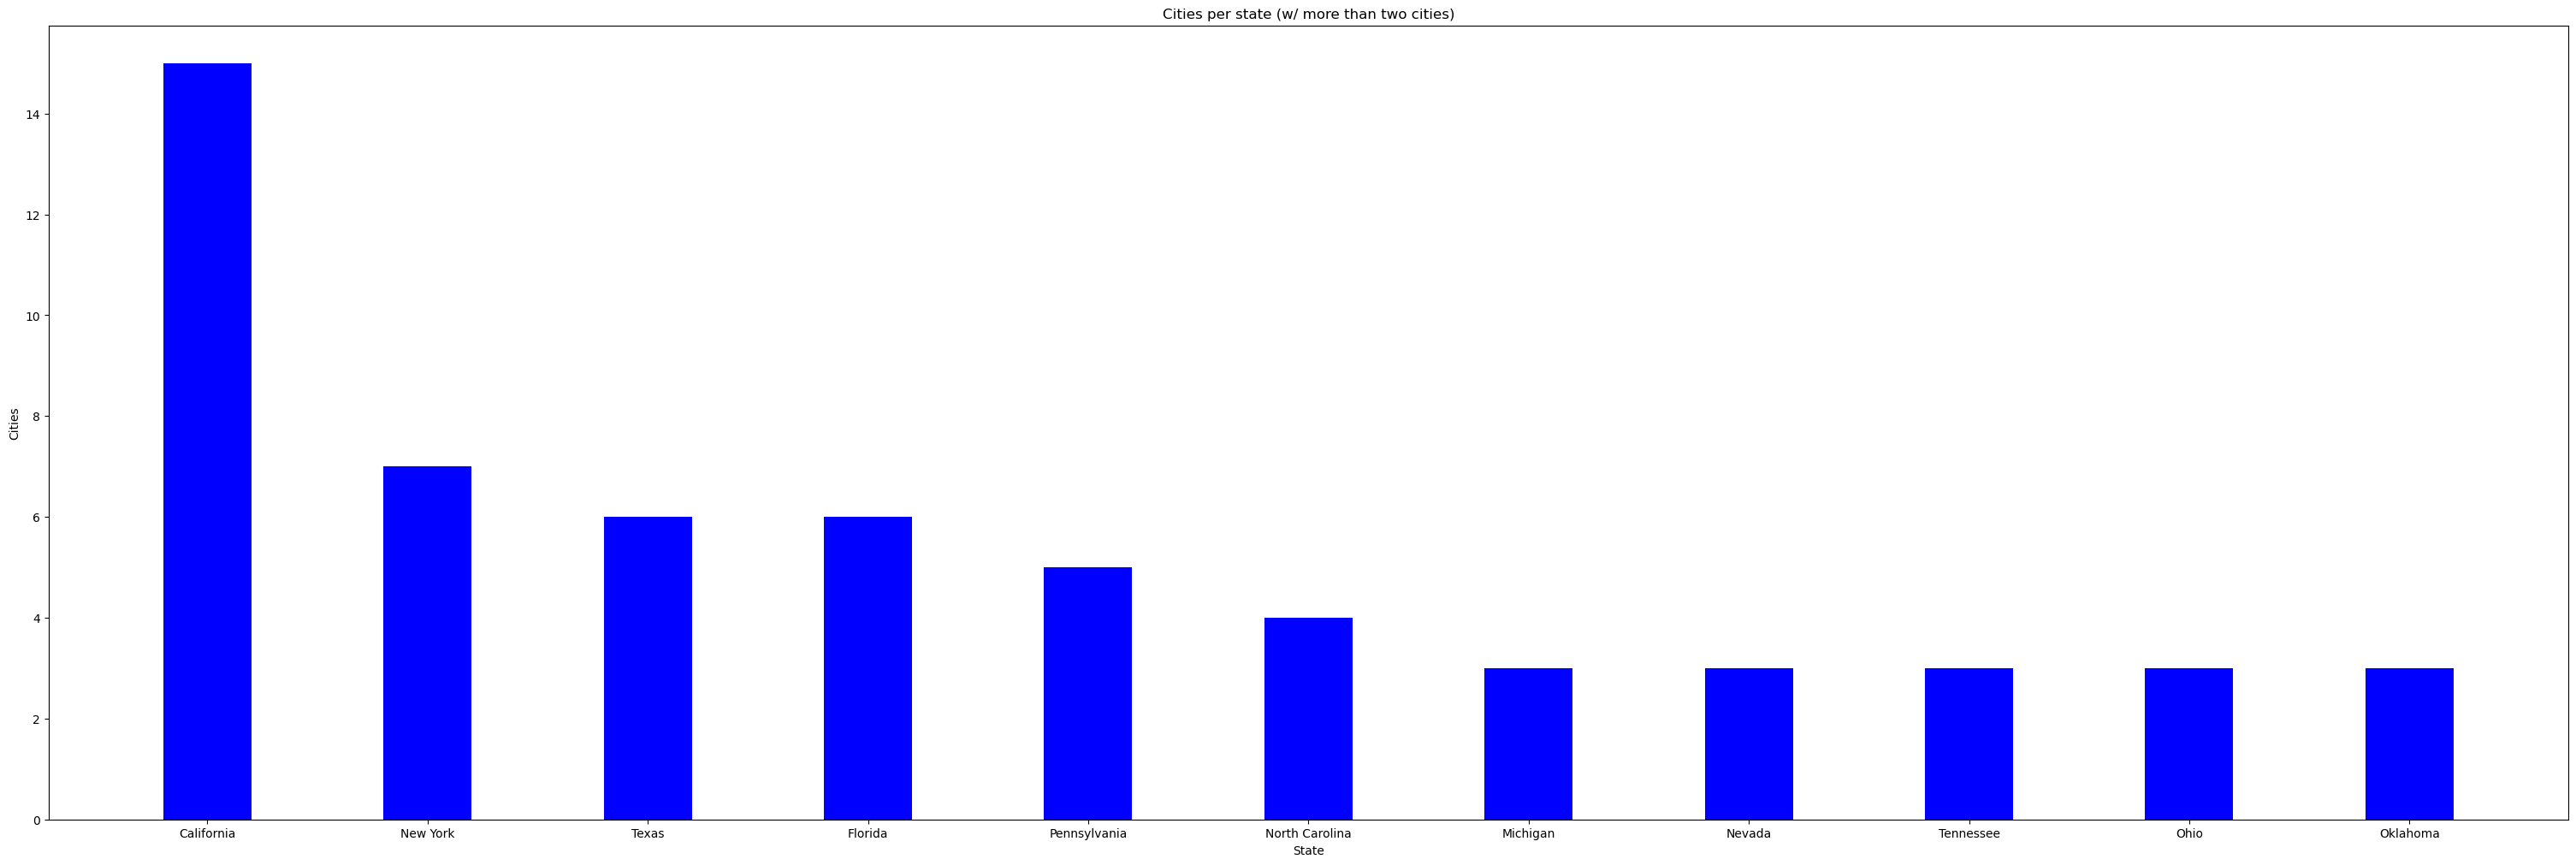

In [451]:
fig2, ax2 = plt.subplots(figsize = (30,10), layout='constrained')
ax2.bar(two_cities['State'], two_cities['Count'], color ='blue', width = 0.4,)
ax2.set_xlabel('State')
ax2.set_ylabel('Cities')
ax2.set_title('Cities per state (w/ more than two cities)')

So, this is nearly unreadable because of how large it is. But trying to mask the data was giving me inaccurate results, and adding .head(15) was giving the top 15 for each - but since they were ordered differently, this meant nothing. I will come back to this problem later.

But, this is the two graphs overlapped. I think it's interesting how there isn't as strict of a correlation between # of cities and times the state is visited. This is something I would run smf.ols on, but it's 11:30.

Text(0, 0.5, 'Instances')

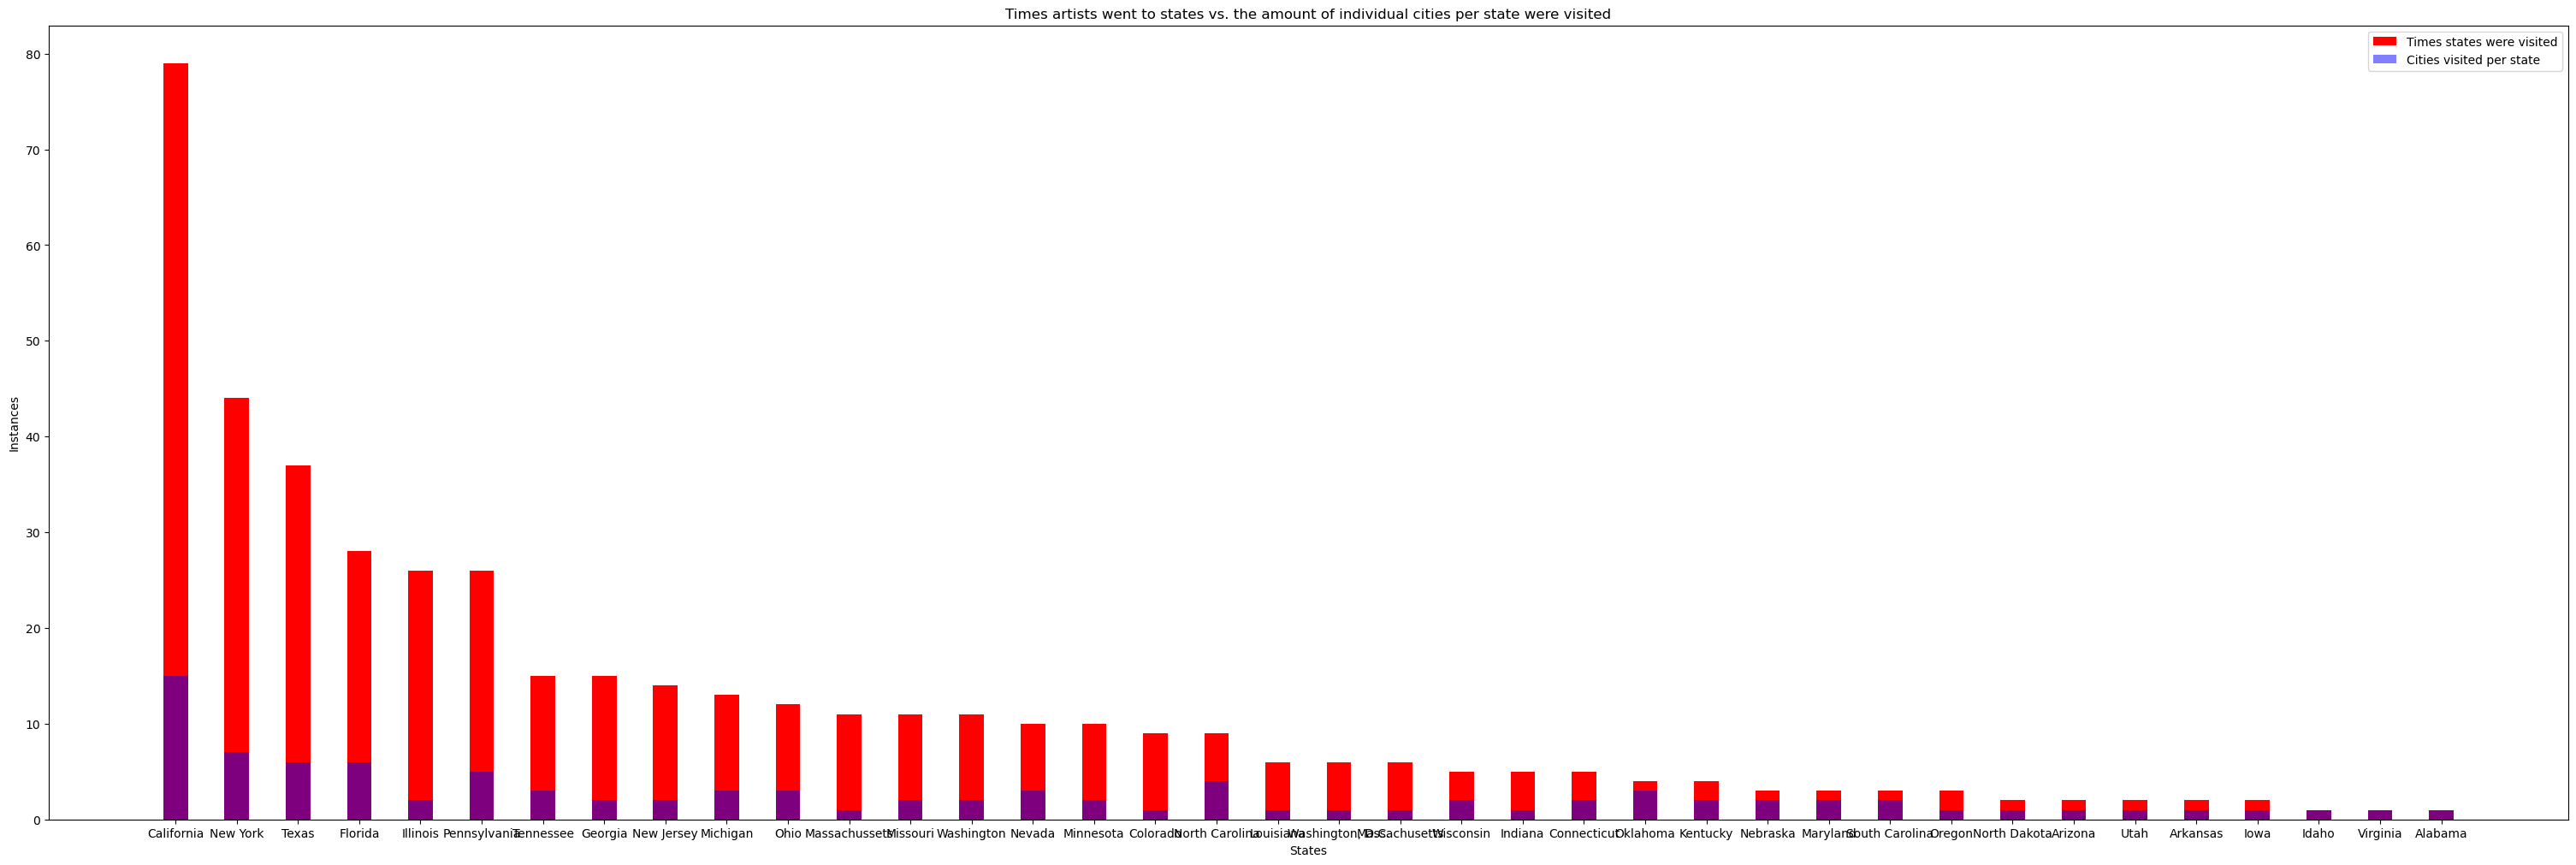

In [424]:
fig3, ax3 = plt.subplots(figsize = (30,10), layout='constrained')
g1 = ax3.bar(state_count_df['State'], state_count_df['Count'], color = 'red', width = 0.4, label = "Times states were visited")
g2 = ax3.bar(num_cities_count_df['State'], num_cities_count_df['Count'], alpha = 0.5, color = 'blue', width = 0.4, label = "Cities visited per state")

ax3.legend(handles = [g1, g2])
ax3.set_title("Times artists went to states vs. the amount of individual cities per state were visited")
ax3.set_xlabel("States")
ax3.set_ylabel("Instances")

This is not displaying correctly, there's less than 38 points. Also, it's a lot less interesting when everything is a solid number and there are no decimals. But I need to incorporate things other than just bar graphs. Not sure how to solve.

Text(0, 0.5, 'Cities')

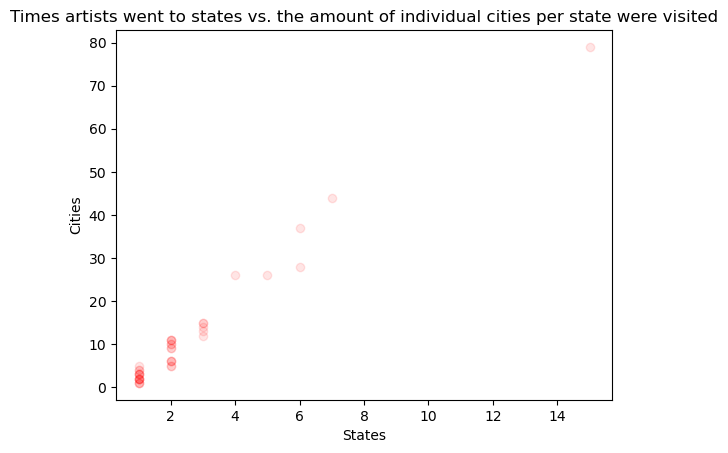

In [443]:
fig3, ax3 = plt.subplots()
ax3.scatter(num_cities_count_df['Count'], state_count_df['Count'], color = 'red', alpha = 0.1, label = "Times states were visited") 
ax3.set_title("Times artists went to states vs. the amount of individual cities per state were visited")
ax3.set_xlabel("States")
ax3.set_ylabel("Cities")

In [413]:
state_rev = tours_merged_df.groupby('State')['Revenue'].sum()
state_rev_df = state_rev.rename_axis('State').reset_index(name='Revenue')
state_rev_df = state_rev_df.sort_values(by='Revenue', ascending = False)

Need to look into how to get the actual numbers on the side rather than decimals - 1.0 is 10 billion, so need to properly label. But revenue per state still follows along with the trend we saw.

Text(0.5, 1.0, 'Revenue per state')

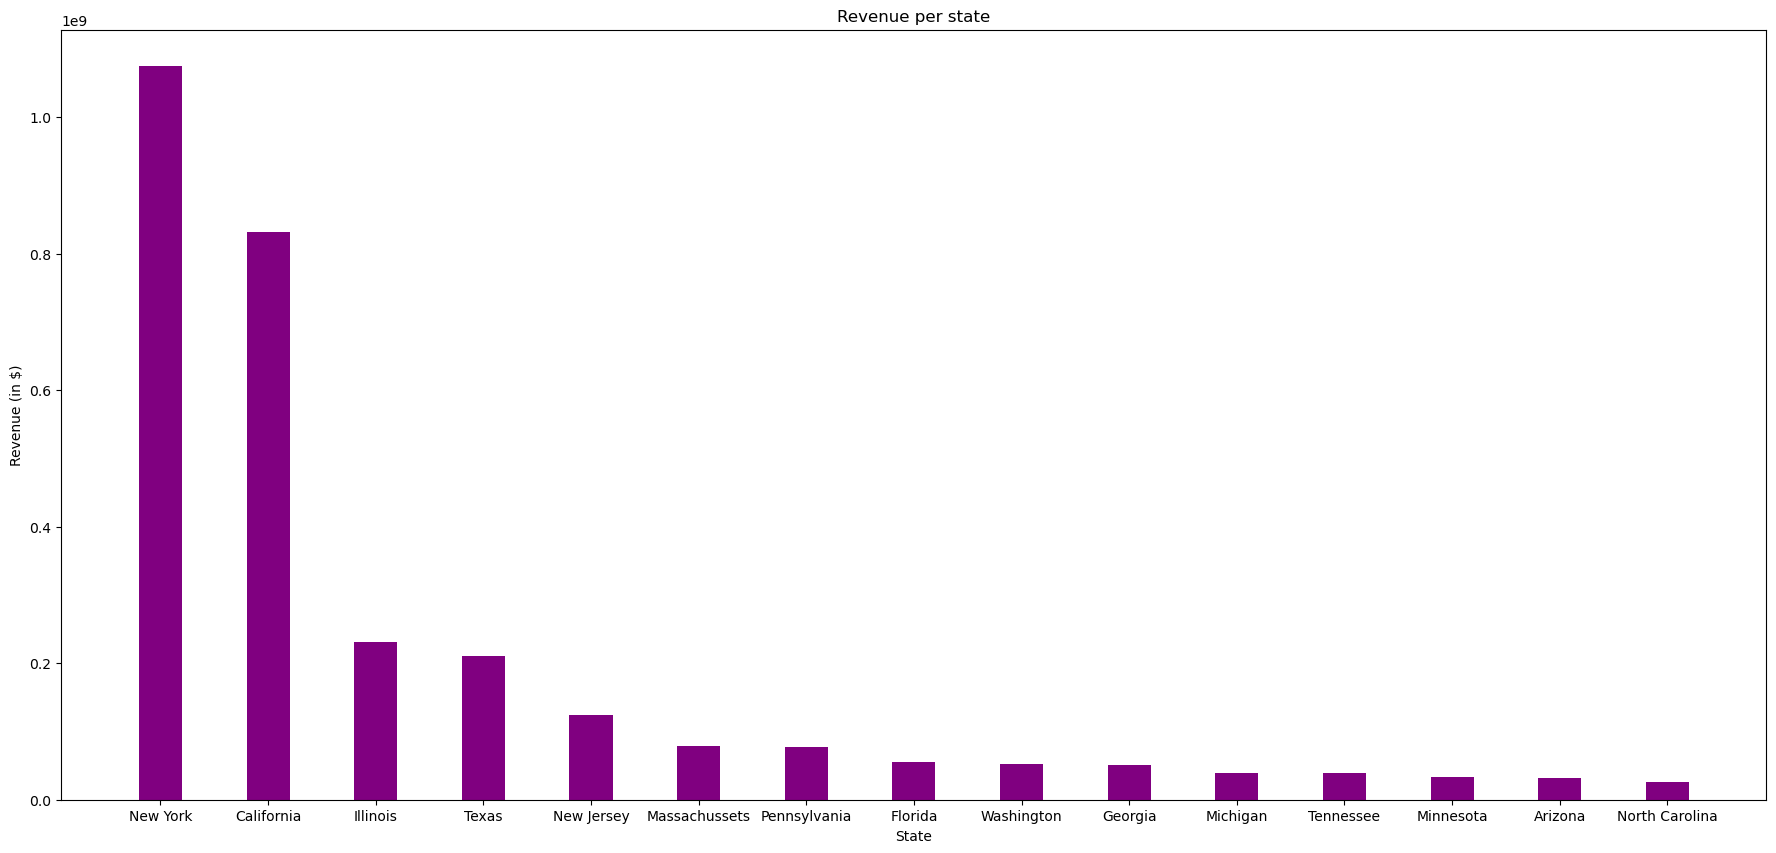

In [444]:
fig4, ax4 = plt.subplots(figsize = (22,10))
ax4.bar(state_rev_df['State'].head(15), state_rev_df['Revenue'].head(15), color ='purple', width = 0.4)
ax4.set_ylabel('Revenue (in $)')
ax4.set_xlabel('State')
ax4.set_title('Revenue per state')

In [430]:
state_attendance = tours_merged_df.groupby('State')['Attendance'].sum()
state_att_df = state_attendance.rename_axis('State').reset_index(name='Attendance')
state_att_df = state_att_df.sort_values(by='Attendance', ascending = False)
# state_att_df.head()

So, nearly the same order as the revenue. But there are a few noticeable changes. I'll overlay them for comparison.

Text(0.5, 1.0, 'Attendees per state')

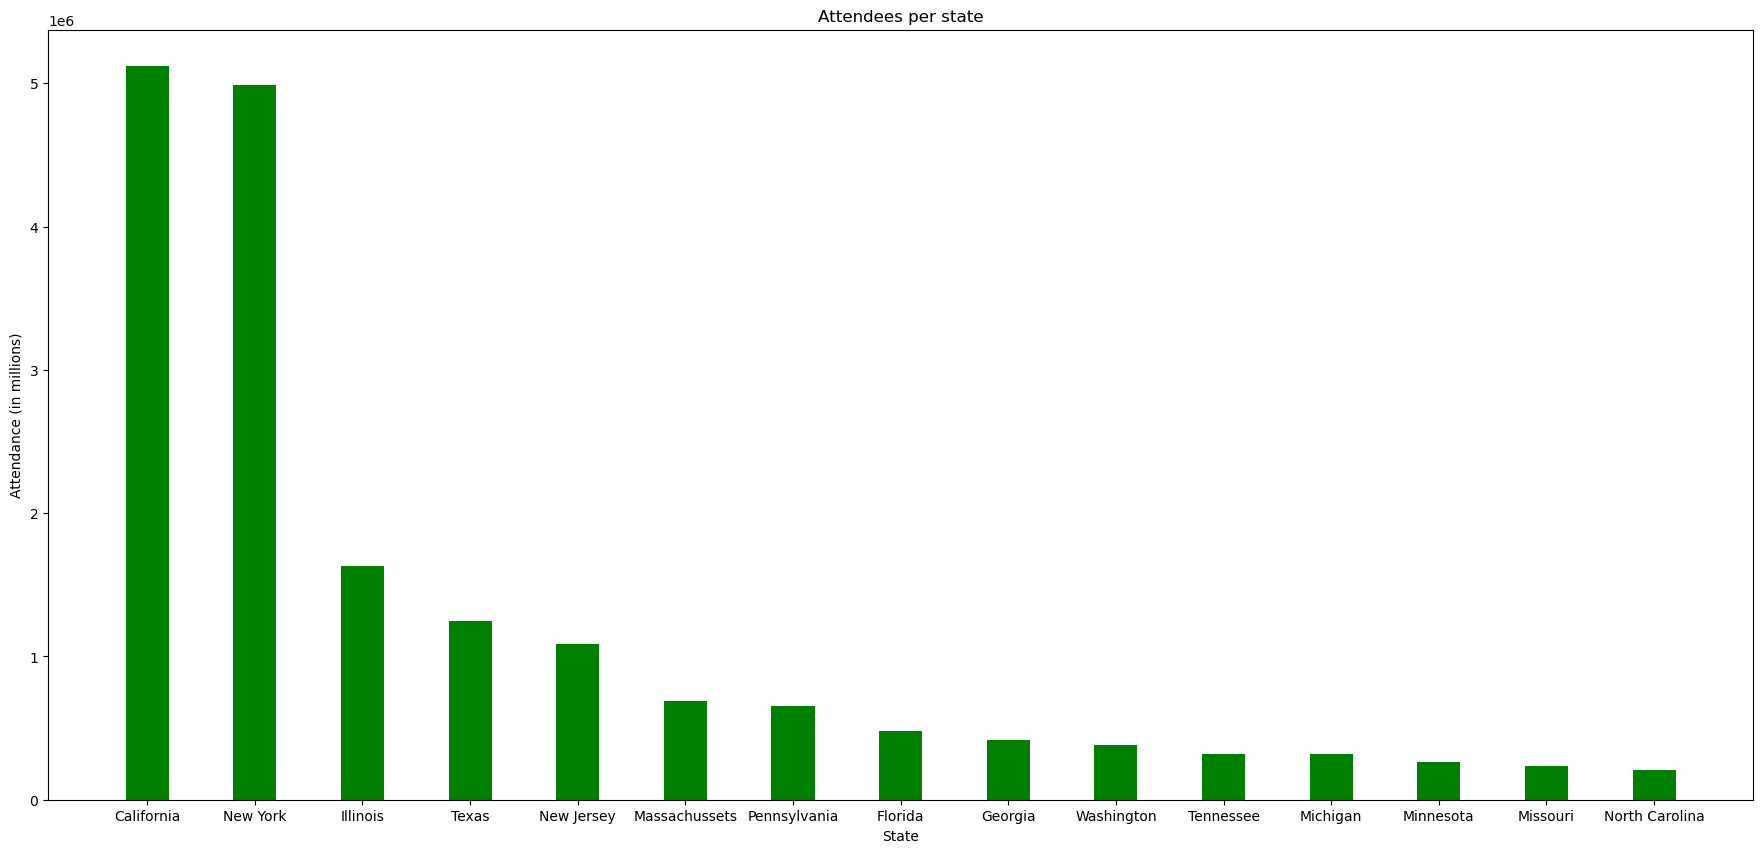

In [431]:
fig5, ax5 = plt.subplots(figsize = (22,10))
ax5.bar(state_att_df['State'].head(15), state_att_df['Attendance'].head(15), color ='green', width = 0.4)
ax5.set_ylabel('Attendance (in millions)')
ax5.set_xlabel('State')
ax5.set_title("Attendees per state")

Well, this is very interesting. Better than the stacked bar I was planning on doing initially. Not sure how to label each individual dot yet (tried it once or twice but I'm running out of time). But the two outliers New York and California make it really hard to read.

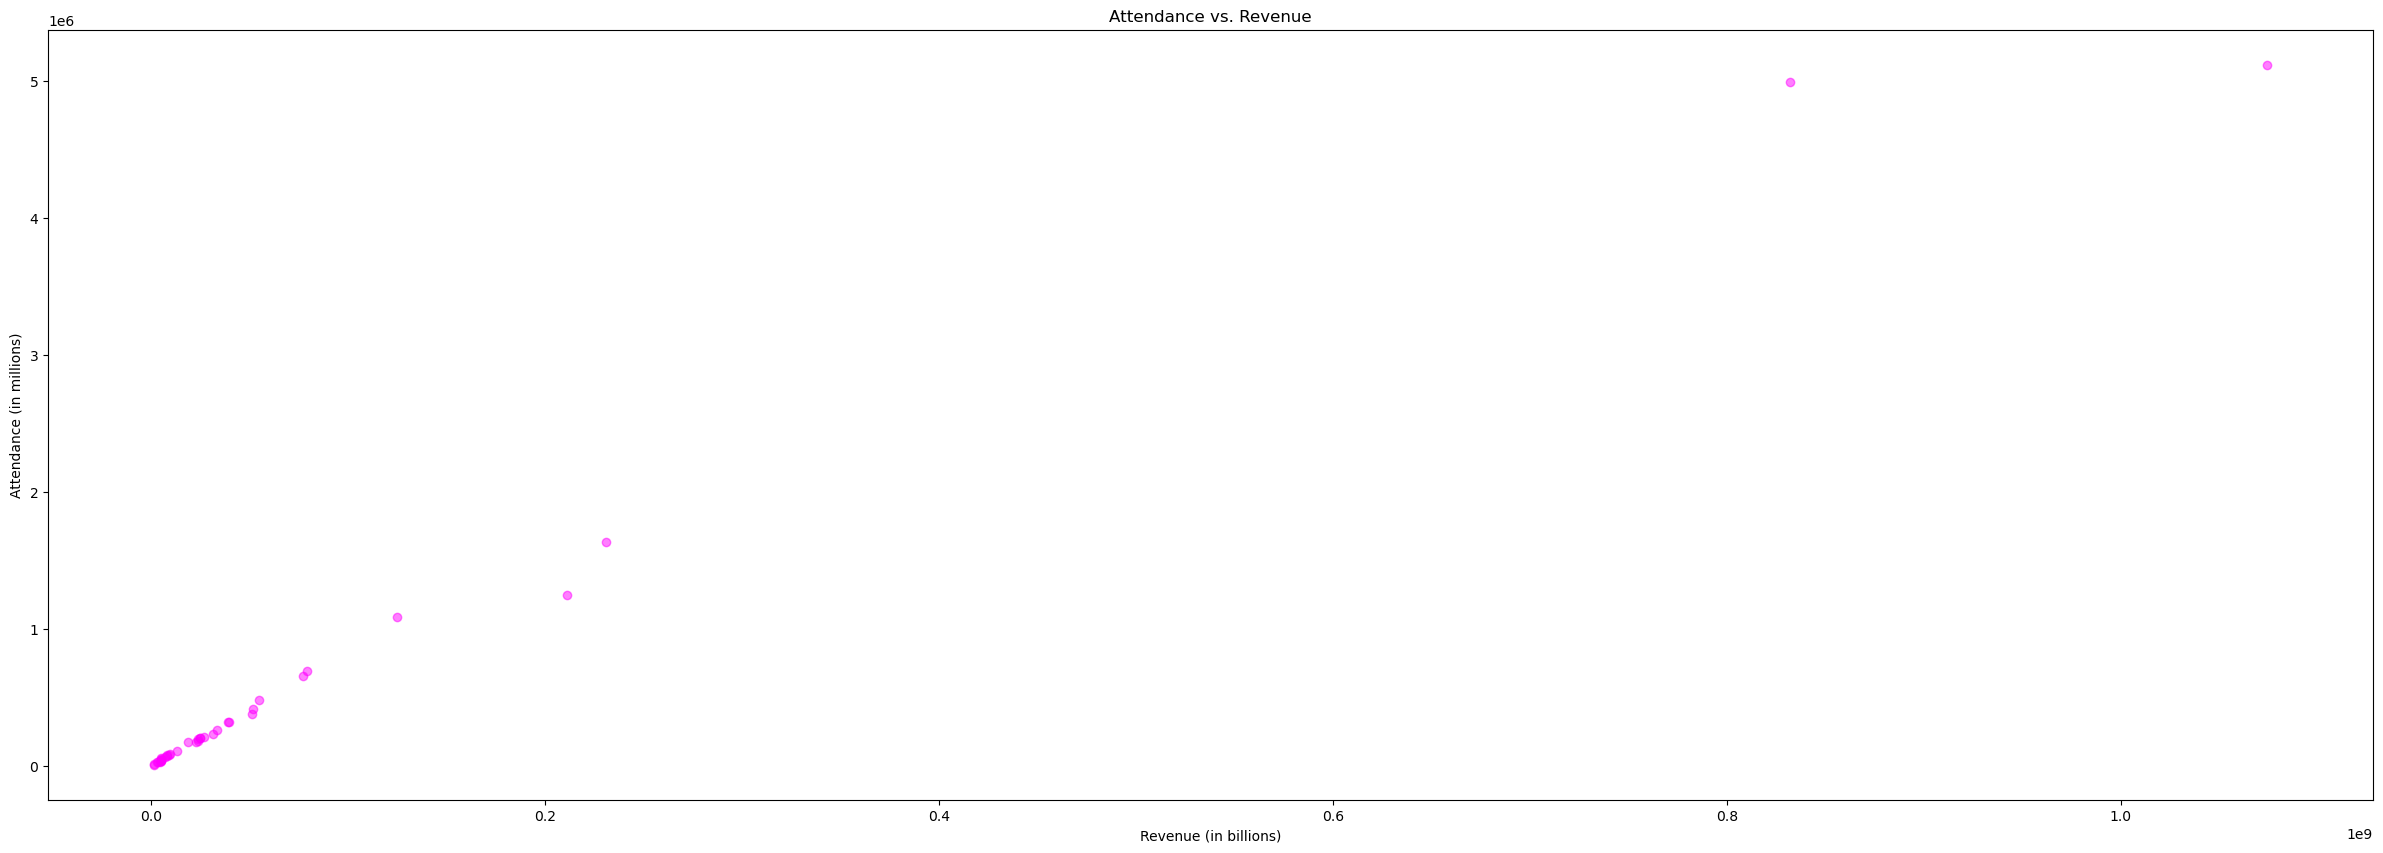

In [450]:
fig3, ax3 = plt.subplots(figsize = (30, 10))
ax3.scatter(state_rev_df['Revenue'], state_att_df['Attendance'], alpha = 0.5, color = 'magenta')

ax3.set_xlabel('Revenue (in billions)')
ax3.set_ylabel('Attendance (in millions)')
ax3.set_title ('Attendance vs. Revenue')
plt.show()

Some of these graphs I need to revisit the lecture on styling graphs (changing font size, making it bold, etc). I also need to think more about the kinds of plots I'm using. It makes sense I would use a lot of histograms, but I want to try and branch out a little (maybe a pie chart). Because there are such huge jumps in the data I am having trouble making visualizations that make sense.

One other chart I would like to compare is # of attendees compared to # of cities per state. Since there isn't a super strong correlation between # of cities and # of visits, I think the attendees might be interesting as well. As well as attendees vs visits to state, since some states are likely to have super big venues vs others. But it's at the point where I feel like I'm bogging this down with more and more graphs, I need help figuring out which ones are the most useful.